# ViP Classification on fashion_mnist

## random_features=32

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import sys
import os
import pickle

# check GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import tensorflow_datasets as tfds
train_dataset, info = tfds.load('fashion_mnist', split='train', shuffle_files=True, with_info=True)
val_dataset = tfds.load('fashion_mnist', split='test', shuffle_files=False)

# number of samples
num_train_samples = tf.data.experimental.cardinality(train_dataset).numpy()
num_val_samples = tf.data.experimental.cardinality(val_dataset).numpy()
print('Number of training samples:', num_train_samples)
print('Number of validation samples:', num_val_samples)

# size of image
for example in train_dataset.take(1):
    image, label = example['image'], example['label']
print('Image size:', image.shape)

# number of classes
num_classes = info.features['label'].num_classes
print('Number of classes: ', num_classes)

Number of training samples: 60000
Number of validation samples: 10000
Image size: (28, 28, 1)
Number of classes:  10


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 64

def extract_image_and_label(example):
    image, label = example['image'], example['label']
    image = tf.cast(image, tf.float32)
    return image, label

# extract image and label from dataloader
train_ds = train_dataset.map(extract_image_and_label)
val_ds = val_dataset.map(extract_image_and_label)

# batch train_ds and val_ds
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

# input pipeline optimization
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [4]:
curr_dir = os.getcwd() 
parent_dir = os.path.abspath(os.path.join(curr_dir, os.pardir))
implementation_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
main_dir = os.path.abspath(os.path.join(implementation_dir, os.pardir))
sys.path.append(main_dir)

In [5]:
from model.vision_performer import VisionPerformer
# compiler attributes
lr = 1e-4
weight_decay = 1e-4
num_epochs = 30

# VisionTransformer attributes
input_shape = image.shape # [28, 28, 1]
image_size = image.shape[0] # 28
channels = image.shape[2] # 1
num_layers = 6
num_classes = num_classes # 10
d_model = 64
num_heads = 1
mlp_dim = 64
# VisionPerformer attributes
random_features = 32
kernel_transformation = 'softmax'

# L = 16

In [6]:
patch_size = 8
model_16 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    VisionPerformer(image_size=image_size, patch_size=patch_size, num_layers=num_layers,
                      num_classes=num_classes, d_model=d_model, num_heads=num_heads, 
                  random_features=random_features, kernel_transformation=kernel_transformation,
                  mlp_dim=mlp_dim, channels=channels),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_16.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay),
             metrics=['accuracy']) 

model_16.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vision_performer (VisionPer  (None, 10)               161098    
 former)                                                         
                                                                 
 dense_39 (Dense)            (None, 10)                110       
                                                                 
Total params: 161,208
Trainable params: 161,208
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_name = 'L_16'
path = main_dir + '\model_checkpoints\\fashion_mnist\ViP\\random_feature_32\\' + model_name

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min'
)

#train model
start_time = time.time()
history_16 = model_16.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]
)
end_time = time.time()
total_time_16 = end_time-start_time

Epoch 1/30
938/938 [==============================] - 83s 74ms/step - loss: 1.3763 - accuracy: 0.4856 - val_loss: 0.9465 - val_accuracy: 0.6540
Epoch 2/30
938/938 [==============================] - 69s 74ms/step - loss: 0.8896 - accuracy: 0.6817 - val_loss: 0.7675 - val_accuracy: 0.7231
Epoch 3/30
938/938 [==============================] - 70s 75ms/step - loss: 0.7501 - accuracy: 0.7349 - val_loss: 0.6907 - val_accuracy: 0.7513
Epoch 4/30
938/938 [==============================] - 71s 76ms/step - loss: 0.6822 - accuracy: 0.7594 - val_loss: 0.6277 - val_accuracy: 0.7743
Epoch 5/30
938/938 [==============================] - 71s 76ms/step - loss: 0.6379 - accuracy: 0.7765 - val_loss: 0.6024 - val_accuracy: 0.7852
Epoch 6/30
938/938 [==============================] - 68s 73ms/step - loss: 0.6111 - accuracy: 0.7846 - val_loss: 0.5950 - val_accuracy: 0.7870
Epoch 7/30
938/938 [==============================] - 68s 73ms/step - loss: 0.5939 - accuracy: 0.7915 - val_loss: 0.5739 - val_accuracy:

In [8]:
from utils import inf_time_check
print(f'Training time {round((total_time_16),3)} sec for {num_epochs} epochs.')
inference_time_16 = inf_time_check(model_16, val_ds)
print(f'Inference time {inference_time_16} ms for {num_val_samples} samples.')

Training time 2130.804 sec for 30 epochs.
64/64 [==============================] - 1s 16ms/step
Inference time 1416.769 ms for 10000 samples.


In [9]:
log_name_16 = '\log\\fashion_mnist\ViP\\random_feature_32\L_16.pkl'
log_path_16 = main_dir + log_name_16
with open(log_path_16, 'wb') as file:
    pickle.dump(history_16.history, file)

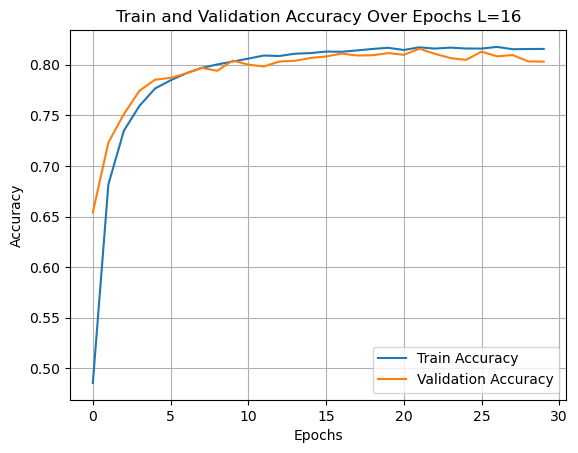

In [10]:
# plot accuracy curve
plt.plot(history_16.history["accuracy"], label="Train Accuracy")
plt.plot(history_16.history["val_accuracy"], label="Validation Accuracy")
plt.title("Train and Validation Accuracy Over Epochs L=16")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

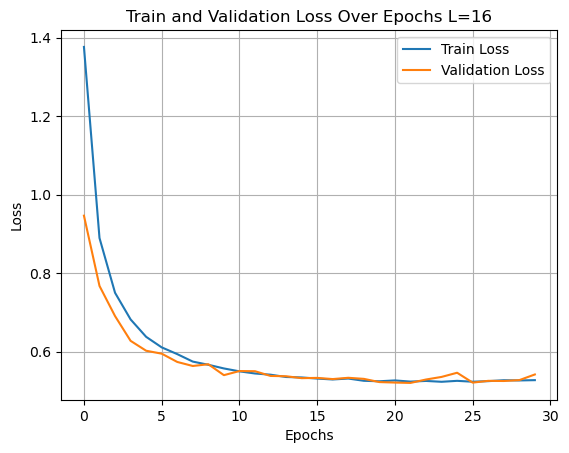

In [11]:
# plot loss curve
plt.plot(history_16.history["loss"], label="Train Loss")
plt.plot(history_16.history["val_loss"], label="Validation Loss")
plt.title("Train and Validation Loss Over Epochs L=16")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# L = 64

In [12]:
patch_size = 4
model_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    VisionPerformer(image_size=image_size, patch_size=patch_size, num_layers=num_layers,
                      num_classes=num_classes, d_model=d_model, num_heads=num_heads, 
                  random_features=random_features, kernel_transformation=kernel_transformation,
                  mlp_dim=mlp_dim, channels=channels),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_64.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay),
             metrics=['accuracy']) 

model_64.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vision_performer_1 (VisionP  (None, 10)               160586    
 erformer)                                                       
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense_79 (Dense)            (None, 10)                110       
                                                                 
Total params: 160,696
Trainable params: 160,696
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_name = 'L_64'
path = main_dir + '\model_checkpoints\\fashion_mnist\ViP\\random_feature_32\\' + model_name

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min'
)

#train model
start_time = time.time()
history_64 = model_64.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]
)
end_time = time.time()
total_time_64 = end_time-start_time

Epoch 1/30
938/938 [==============================] - 73s 69ms/step - loss: 1.4270 - accuracy: 0.4457 - val_loss: 1.0043 - val_accuracy: 0.6098
Epoch 2/30
938/938 [==============================] - 62s 66ms/step - loss: 0.9397 - accuracy: 0.6416 - val_loss: 0.8301 - val_accuracy: 0.6846
Epoch 3/30
938/938 [==============================] - 60s 64ms/step - loss: 0.7898 - accuracy: 0.7143 - val_loss: 0.7076 - val_accuracy: 0.7348
Epoch 4/30
938/938 [==============================] - 62s 66ms/step - loss: 0.6930 - accuracy: 0.7530 - val_loss: 0.6309 - val_accuracy: 0.7670
Epoch 5/30
938/938 [==============================] - 61s 65ms/step - loss: 0.6344 - accuracy: 0.7755 - val_loss: 0.5881 - val_accuracy: 0.7843
Epoch 6/30
938/938 [==============================] - 61s 65ms/step - loss: 0.6017 - accuracy: 0.7859 - val_loss: 0.5729 - val_accuracy: 0.7945
Epoch 7/30
938/938 [==============================] - 61s 65ms/step - loss: 0.5776 - accuracy: 0.7957 - val_loss: 0.5512 - val_accuracy:

In [14]:
print(f'Training time {round((total_time_64),3)} sec for {num_epochs} epochs.')
inference_time_64 = inf_time_check(model_64, val_ds)
print(f'Inference time {inference_time_64} ms for {num_val_samples} samples.')

Training time 1831.729 sec for 30 epochs.
64/64 [==============================] - 1s 21ms/step
Inference time 1554.224 ms for 10000 samples.


In [15]:
log_name_64 = '\log\\fashion_mnist\ViP\\random_feature_32\L_64.pkl'
log_path_64 = main_dir + log_name_64
with open(log_path_64, 'wb') as file:
    pickle.dump(history_64.history, file)

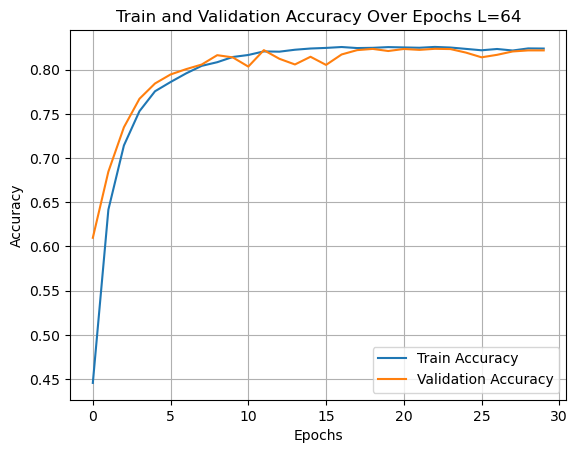

In [16]:
# plot accuracy curve
plt.plot(history_64.history["accuracy"], label="Train Accuracy")
plt.plot(history_64.history["val_accuracy"], label="Validation Accuracy")
plt.title("Train and Validation Accuracy Over Epochs L=64")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

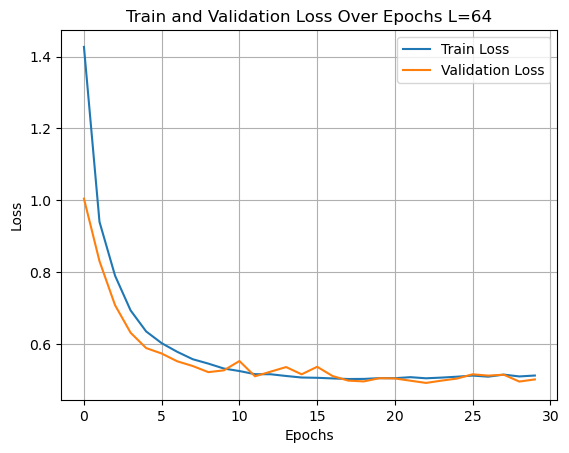

In [17]:
# plot loss curve
plt.plot(history_64.history["loss"], label="Train Loss")
plt.plot(history_64.history["val_loss"], label="Validation Loss")
plt.title("Train and Validation Loss Over Epochs L=64")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# L = 256

In [18]:
patch_size = 2
model_256 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    VisionPerformer(image_size=image_size, patch_size=patch_size, num_layers=num_layers,
                      num_classes=num_classes, d_model=d_model, num_heads=num_heads, 
                  random_features=random_features, kernel_transformation=kernel_transformation,
                  mlp_dim=mlp_dim, channels=channels),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_256.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay),
             metrics=['accuracy']) 

model_256.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vision_performer_2 (VisionP  (None, 10)               169226    
 erformer)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_119 (Dense)           (None, 10)                110       
                                                                 
Total params: 169,336
Trainable params: 169,336
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_name = 'L_256'
path = main_dir + '\model_checkpoints\\fashion_mnist\ViP\\random_feature_32\\' + model_name

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min'
)

#train model
start_time = time.time()
history_256 = model_256.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]
)
end_time = time.time()
total_time_256 = end_time-start_time

Epoch 1/30
938/938 [==============================] - 75s 71ms/step - loss: 1.4815 - accuracy: 0.4521 - val_loss: 0.9312 - val_accuracy: 0.6658
Epoch 2/30
938/938 [==============================] - 66s 70ms/step - loss: 0.8390 - accuracy: 0.7009 - val_loss: 0.6935 - val_accuracy: 0.7499
Epoch 3/30
938/938 [==============================] - 66s 70ms/step - loss: 0.6872 - accuracy: 0.7598 - val_loss: 0.6333 - val_accuracy: 0.7761
Epoch 4/30
938/938 [==============================] - 64s 68ms/step - loss: 0.6231 - accuracy: 0.7823 - val_loss: 0.5725 - val_accuracy: 0.7979
Epoch 5/30
938/938 [==============================] - 65s 69ms/step - loss: 0.5836 - accuracy: 0.7974 - val_loss: 0.5563 - val_accuracy: 0.7977
Epoch 6/30
938/938 [==============================] - 65s 69ms/step - loss: 0.5589 - accuracy: 0.8055 - val_loss: 0.5268 - val_accuracy: 0.8113
Epoch 7/30
938/938 [==============================] - 65s 69ms/step - loss: 0.5351 - accuracy: 0.8133 - val_loss: 0.5123 - val_accuracy:

In [20]:
from utils import inf_time_check
print(f'Training time {round((total_time_256),3)} sec for {num_epochs} epochs.')
inference_time_256 = inf_time_check(model_256, val_ds)
print(f'Inference time {inference_time_256} ms for {num_val_samples} samples.')

Training time 1948.334 sec for 30 epochs.
64/64 [==============================] - 1s 16ms/step
Inference time 1198.686 ms for 10000 samples.


In [21]:
log_name_256 = '\log\\fashion_mnist\ViP\\random_feature_32\L_256.pkl'
log_path_256 = main_dir + log_name_256
with open(log_path_256, 'wb') as file:
    pickle.dump(history_256.history, file)

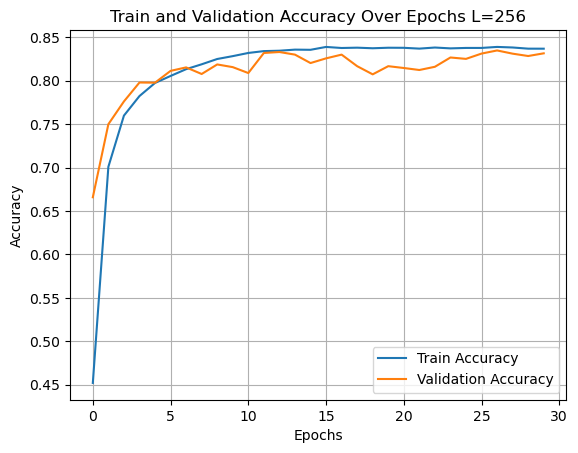

In [22]:
# plot accuracy curve
plt.plot(history_256.history["accuracy"], label="Train Accuracy")
plt.plot(history_256.history["val_accuracy"], label="Validation Accuracy")
plt.title("Train and Validation Accuracy Over Epochs L=256")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

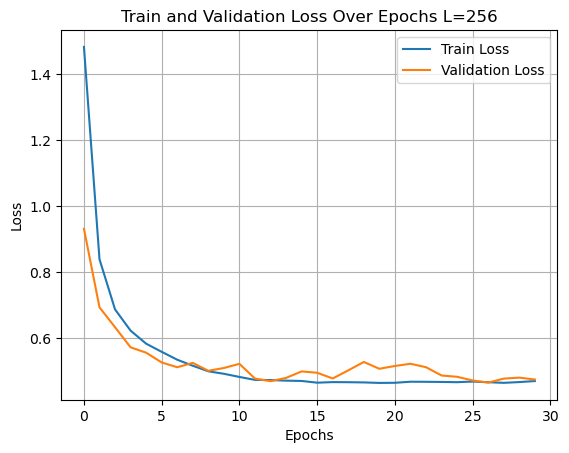

In [23]:
# plot loss curve
plt.plot(history_256.history["loss"], label="Train Loss")
plt.plot(history_256.history["val_loss"], label="Validation Loss")
plt.title("Train and Validation Loss Over Epochs L=256")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# L = 1024

In [24]:
patch_size = 1
model_1024 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    VisionPerformer(image_size=image_size, patch_size=patch_size, num_layers=num_layers,
                      num_classes=num_classes, d_model=d_model, num_heads=num_heads, 
                  random_features=random_features, kernel_transformation=kernel_transformation,
                  mlp_dim=mlp_dim, channels=channels),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_1024.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay),
             metrics=['accuracy']) 

model_1024.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vision_performer_3 (VisionP  (None, 10)               206666    
 erformer)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 10)                0         
                                                                 
 dense_159 (Dense)           (None, 10)                110       
                                                                 
Total params: 206,776
Trainable params: 206,776
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_name = 'L_1024'
path = main_dir + '\model_checkpoints\\fashion_mnist\ViP\\random_feature_32\\' + model_name

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min'
)

#train model
start_time = time.time()
history_1024 = model_1024.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]
)
end_time = time.time()
total_time_1024 = end_time-start_time

Epoch 1/30
938/938 [==============================] - 141s 142ms/step - loss: 1.1668 - accuracy: 0.5583 - val_loss: 0.7138 - val_accuracy: 0.7294
Epoch 2/30
938/938 [==============================] - 131s 140ms/step - loss: 0.6451 - accuracy: 0.7713 - val_loss: 0.5752 - val_accuracy: 0.7943
Epoch 3/30
938/938 [==============================] - 132s 141ms/step - loss: 0.5601 - accuracy: 0.8034 - val_loss: 0.5368 - val_accuracy: 0.8075
Epoch 4/30
938/938 [==============================] - 131s 140ms/step - loss: 0.5184 - accuracy: 0.8192 - val_loss: 0.4928 - val_accuracy: 0.8246
Epoch 5/30
938/938 [==============================] - 131s 140ms/step - loss: 0.4909 - accuracy: 0.8302 - val_loss: 0.4796 - val_accuracy: 0.8305
Epoch 6/30
938/938 [==============================] - 131s 140ms/step - loss: 0.4727 - accuracy: 0.8378 - val_loss: 0.4830 - val_accuracy: 0.8315
Epoch 7/30
938/938 [==============================] - 131s 140ms/step - loss: 0.4575 - accuracy: 0.8427 - val_loss: 0.4674 -

In [26]:
print(f'Training time {round((total_time_1024),3)} sec for {num_epochs} epochs.')
inference_time_1024 = inf_time_check(model_1024, val_ds)
print(f'Inference time {inference_time_1024} ms for {num_val_samples} samples.')

Training time 3948.982 sec for 30 epochs.
64/64 [==============================] - 1s 15ms/step
Inference time 1167.899 ms for 10000 samples.


In [27]:
log_name_1024 = '\log\\fashion_mnist\ViP\\random_feature_32\L_1024.pkl'
log_path_1024 = main_dir + log_name_1024
with open(log_path_1024, 'wb') as file:
    pickle.dump(history_1024.history, file)

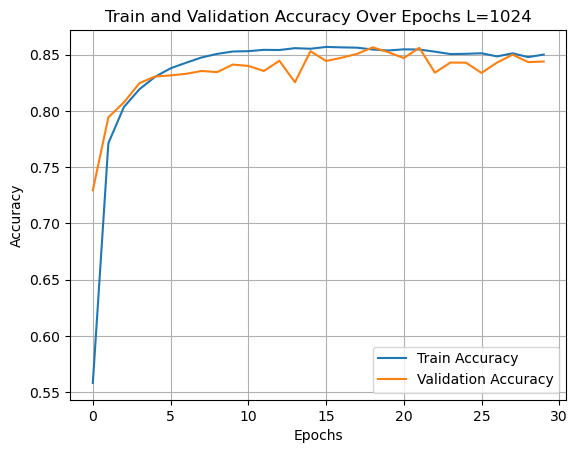

In [28]:
# plot accuracy curve
plt.plot(history_1024.history["accuracy"], label="Train Accuracy")
plt.plot(history_1024.history["val_accuracy"], label="Validation Accuracy")
plt.title("Train and Validation Accuracy Over Epochs L=1024")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

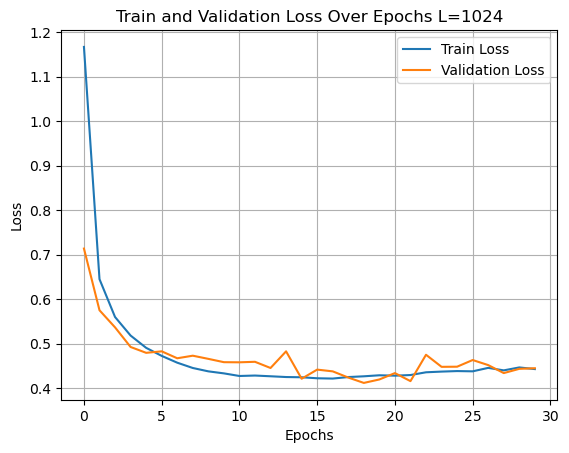

In [29]:
# plot loss curve
plt.plot(history_1024.history["loss"], label="Train Loss")
plt.plot(history_1024.history["val_loss"], label="Validation Loss")
plt.title("Train and Validation Loss Over Epochs L=1024")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

In [30]:
total_time = [total_time_16, total_time_64, total_time_256, total_time_1024]
inference_time = [inference_time_16, inference_time_64, inference_time_256, inference_time_1024]
log = []
log.append(total_time)
log.append(inference_time)
log_name = '\log\\fashion_mnist\ViP\\random_feature_32\\total_inf_time'
log_path = main_dir + log_name
# log [total_time, inference_time]
with open(log_path, 'wb') as file:
    pickle.dump(log, file)

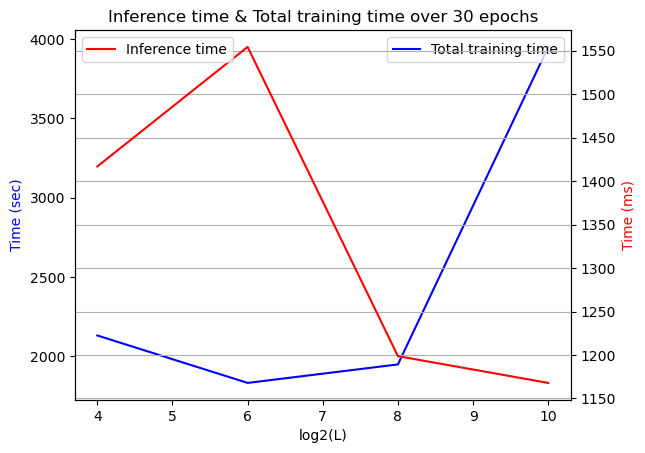

In [31]:
logL = np.log2([16, 64, 256, 1024])

fig, ax1 = plt.subplots()
plt.title(f'Inference time & Total training time over {num_epochs} epochs')
plt.xlabel('log2(L)')

ax1.plot(logL, total_time, color='blue', label='Total training time')
ax1.set_ylabel('Time (sec)', color='blue')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(logL, inference_time, color='red', label='Inference time')
ax2.set_ylabel('Time (ms)', color='red')
ax2.legend(loc='upper left')

plt.grid()
plt.show()